In [11]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import root
from scipy.constants import epsilon_0, mu_0
%matplotlib inline

# Branch points in a coplanar waveguide coupler

In [2]:
# 2 coplanar waveguides on the real axis
def z_branch_points_cpw(s1,s2,w1,w2,w3):
    z_B = 0
    z_C = z_B+s2
    z_D = z_C+w2
    z_E = z_D+s2
    z_F = z_E+w3
    z_G = z_F+s1
    z_H = z_G+w1
    z_I = z_H+s1    
    return [np.complex(x) for x in [z_B, z_C, z_D, z_E, z_F, z_G, z_H, z_I]]

# Conformal transformation of the planar structure to a rectangle

In [3]:
def conformal_transform_difference_by_parts(z0,z1,branch_point1,branch_point2,branch_points,zero_points):
    # 1) solving integral part (positive)
    f1 = lambda z: np.log(z-(branch_points[branch_point1] + branch_points[branch_point2])/2 + \
                       np.sqrt((z-branch_points[branch_point1])*(z-branch_points[branch_point2]))) * \
                       np.prod([z-zero_point for zero_point in zero_points]) / \
                       np.prod([np.sqrt(z-branch_point) for branch_point_id, branch_point \
                       in enumerate(branch_points) if branch_point_id not in [branch_point1, branch_point2]])
    f2 = lambda z: np.log(z-(branch_points[branch_point1] + branch_points[branch_point2])/2 + \
                       np.sqrt((z-branch_points[branch_point1])*(z-branch_points[branch_point2]))) * \
                       np.sum([np.prod([(z-zero_point) for zero_point_id, zero_point in enumerate(zero_points) \
                       if zero_point_id != diff_zero_point_id])/ \
                       np.prod([np.sqrt(z-branch_point) for branch_point_id, branch_point \
                       in enumerate(branch_points) if branch_point_id not in [branch_point1, branch_point2]]) \
                       for diff_zero_point_id, diff_zero_point in enumerate(zero_points)]+ \
                       [np.prod([z-zero_point for zero_point in zero_points]) / \
                       np.prod([np.sqrt(z-branch_point) for branch_point_id, branch_point \
                       in enumerate(branch_points) if branch_point_id not in [branch_point1, branch_point2]]) / \
                       (z-diff_branch_point)*(-0.5) for diff_branch_point_id, diff_branch_point in enumerate(branch_points) \
                       if diff_branch_point_id not in [branch_point1, branch_point2] ])
    
    integral_part = f1(z1)-f1(z0)
    numerical_part = np.complex(*tuple(integrate.quad(lambda t: f2(t*(z1-z0)+z0).real, 0, 1)))+1j*np.complex(*tuple(integrate.quad(lambda t: f2(t*(z1-z0)+z0).imag, 0, 1)))
    
    return integral_part - (z1-z0)*numerical_part   

# Calculate the confromal transform on all branch points

In [4]:
def w_special_points(z_branch_points, z_zero_points):
    w_branch_points = []
    for branch_point_id, z_branch_point in enumerate(z_branch_points):
        if branch_point_id==0:
            w_branch_points.append(0)
        else:            
            w_branch_points.append(w_branch_points[branch_point_id-1] + \
            conformal_transform_difference_by_parts(\
            z_branch_points[branch_point_id-1],z_branch_points[branch_point_id],\
            branch_point_id-1,branch_point_id,z_branch_points,z_zero_points))
    
    w_zero_points = []        
    for zero_point_id, z_zero_point in enumerate(z_zero_points):
        nearest_branch_points = np.argsort(np.abs(np.asarray(z_branch_points)-z_zero_point))[:2]
        w_zero_points.append(w_branch_points[nearest_branch_points[0]] + \
            conformal_transform_difference_by_parts(\
                z_branch_points[nearest_branch_points[0]],\
                z_zero_point,\
                nearest_branch_points[0],\
                nearest_branch_points[1],\
                z_branch_points,
                z_zero_points))
    return w_branch_points, w_zero_points

# Function to find the zero points of the transform derivative from the potential of the ports

In [5]:
def find_zero_points(z_branch_points, z_zero_points_initial, z_zero_point_types, constraint_point_ids, constraint_types):
    def constraint(t_zero_points):
        w_branch_points, w_zero_points = w_special_points(z_branch_points, \
        [t if point_type=='real' else 1j*t for t,point_type in zip(t_zero_points, z_zero_point_types)]) 
        z_B,z_C,z_D,z_E,z_F,z_G,z_H,z_I = z_branch_points           
        w_B,w_C,w_D,w_E,w_F,w_G,w_H,w_I = w_branch_points
        constraint_values = \
        [w_branch_points[constraint_point_id[0]].real-w_branch_points[constraint_point_id[1]].real \
         if constraint_types[constraint_id] == 'real' else \
         w_branch_points[constraint_point_id[0]].imag-w_branch_points[constraint_point_id[1]].imag \
         for constraint_id, constraint_point_id in enumerate(constraint_point_ids)]
        return constraint_values
        
    return root(constraint, z_zero_points_initial).x

# Derivative of the conformal transform (defines the electric and magnetic fields)

In [6]:
def conformal_transform_derivative(z,z_branch_points,z_zero_points):
    result = 1
    for branch_point_id, branch_point in enumerate(z_branch_points):
        result /= np.sqrt(z-branch_point)
    for zero_point_id, zero_point in enumerate(z_zero_points):
        result *= (z-zero_point)
    return result

# Defining geometric properties of the coplanar waveguide coupler

In [7]:
w = 10
s = 6
s1 = 6
s2 = 12
w1 = 10
w2 = 20
w3 = 5

# Evaluating the conformal transform special points (zeros and branch points) if when of the nodes has a potential and all others are grounded (z-space & w-space)

In [8]:
z_branch_points = z_branch_points_cpw(s1,s2,w1,w2,w3)
z_zero_points_initial = [(z_branch_points[4]+z_branch_points[5]).real/2, \
                         (z_branch_points[6]+z_branch_points[7]).real/2]
z_zero_points = find_zero_points(z_branch_points, z_zero_points_initial, ['real', 'real'], \
                                        [(3,0),(5,0)], ['imag', 'imag'])
w_branch_points, w_zero_points = w_special_points(z_branch_points, z_zero_points)
z_B,z_C,z_D,z_E,z_F,z_G,z_H,z_I = z_branch_points
w_B,w_C,w_D,w_E,w_F,w_G,w_H,w_I = w_branch_points
z_F1,z_H1 = z_zero_points
w_F1,w_H1 = w_zero_points

# plotting conformal transform & fields

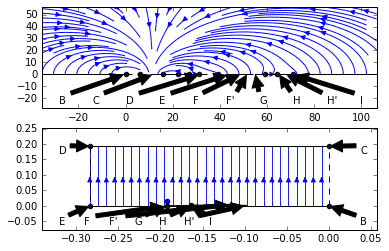

In [12]:
x = np.linspace(-(2*s2+2*s1+w1+w2+w3)*0.5,(2*s2+2*s1+w1+w2+w3)*1.5,251)
y = np.linspace(0, (np.max(x)-np.min(x))*0.4, 201)

plt.figure(0)
plt.clf()
axes=plt.subplot(2,1,1)
vertices = [i for i in z_zero_points] + [i for i in z_branch_points]
lines = [(z_B-100,z_B,'-'),(z_B,z_C,'--'),(z_C,z_D,'-'),(z_D,z_E,'--'),(z_E,z_F,'-'),\
         (z_F,z_F1,'-'),(z_F1,z_G,'--'),(z_G,z_H,'-'),(z_H,z_H1,'-'),(z_H1,z_I,'--'),(z_I,z_I+100,'-')]
for z1,z2,style in lines:
    plt.plot([z1.real, z2.real], [z1.imag, z2.imag], color='black', linestyle=style)

plt.xlim(np.min(x), np.max(x))
plt.ylim(-0.5*np.max(y), np.max(y))

plt.scatter([j.real for j in vertices], [j.imag for j in vertices])

[xm,ym] = np.meshgrid(x,y)
um = conformal_transform_derivative(xm+1j*ym,z_branch_points,z_zero_points).real
vm = conformal_transform_derivative(xm+1j*ym,z_branch_points,z_zero_points).imag
wm = np.zeros(um.shape, dtype=np.complex)
plt.streamplot(x,y,vm,um)

annotations = ['B', 'C', 'D', 'E', 'F', 'F\'', 'G', 'H', 'H\'', 'I']
annotation_positions = [(a*0.10+0.05, 0.05) for a in range(10)]
annotation_points = [z_B,z_C,z_D,z_E,z_F,z_F1,z_G,z_H,z_H1,z_I]

for annotation, annotation_position, annotation_point in zip(annotations, annotation_positions, annotation_points):
    axes.annotate(annotation, xy=(annotation_point.real, annotation_point.imag), xytext=annotation_position, 
              xycoords='data',  textcoords='axes fraction', arrowprops={'facecolor':'black', 'shrink':0.05})
    
    
axes=plt.subplot(2,1,2)
vertices = [i for i in w_zero_points] + [i for i in w_branch_points]
lines = [(w_B,w_C,'--'),(w_C,w_D,'-'),(w_D,w_E,'--'),(w_E,w_F,'-'),\
         (w_F,w_F1,'-'),(w_F1,w_G,'--'),(w_G,w_H,'-'),(w_H,w_H1,'-'),(w_H1,w_I,'--'),(w_I,w_B,'-')]
for z1,z2,style in lines:
    plt.plot([z1.real, z2.real], [z1.imag, z2.imag], color='black', linestyle=style)
    
plt.scatter([j.real for j in vertices], [j.imag for j in vertices])

wx = np.linspace(w_E.real, w_B.real, 251)
wy = np.linspace(w_B.imag, w_C.imag, 101)
wxm,wym = np.meshgrid(wx,wy)
wvm = 0*np.ones(wxm.shape)
wum = 1*np.ones(wxm.shape)
plt.streamplot(wxm,wym,wvm,wum)

plt.xlim([w_E.real-(w_B.real-w_E.real)*0.2, w_B.real+(w_B.real-w_E.real)*0.2])
plt.ylim([w_B.imag-(w_C.imag-w_B.imag)*0.4, w_C.imag+(w_C.imag-w_B.imag)*0.3])

annotations = ['B', 'C', 'D', 'E', 'F', 'F\'', 'G', 'H', 'H\'', 'I']
annotation_positions = [(0.95, 0.05), (0.95, 0.75), (0.05, 0.75), (0.05, 0.05), (0.125, 0.05), \
                        (0.20, 0.05), (0.275, 0.05), (0.35, 0.05), (0.425, 0.05), (0.5, 0.05),]
annotation_points = [w_B,w_C,w_D,w_E,w_F,w_F1,w_G,w_H,w_H1,w_I]

for annotation, annotation_position, annotation_point in zip(annotations, annotation_positions, annotation_points):
    axes.annotate(annotation, xy=(annotation_point.real, annotation_point.imag), xytext=annotation_position, 
              xycoords='data',  textcoords='axes fraction', arrowprops={'facecolor':'black', 'shrink':0.05})

# Putting the potential on each of the waveguides and evaluating the capacitance matrix vector

In [10]:
z_branch_points = z_branch_points_cpw(s1,s2,w1,w2,w3)
z_zero_points_initial = [(z_branch_points[4]+z_branch_points[5]).real/2, \
                         (z_branch_points[6]+z_branch_points[7]).real/2]
z_zero_points = find_zero_points(z_branch_points, z_zero_points_initial, ['real', 'real'], \
                                        [(3,0),(5,0)], ['imag', 'imag'])
w_branch_points, w_zero_points = w_special_points(z_branch_points, z_zero_points)
w_B,w_C,w_D,w_E,w_F,w_G,w_H,w_I = w_branch_points
c1_ = [(w_C.real-w_D.real)/(w_C.imag-w_B.imag), (w_G.real-w_H.real)/(w_C.imag-w_B.imag)]

z_branch_points = z_branch_points_cpw(s2,s1,w2,w1,w3)
z_zero_points_initial = [(z_branch_points[4]+z_branch_points[5]).real/2, \
                         (z_branch_points[6]+z_branch_points[7]).real/2]
z_zero_points = find_zero_points(z_branch_points, z_zero_points_initial, ['real', 'real'], \
                                        [(3,0),(5,0)], ['imag', 'imag'])
w_branch_points, w_zero_points = w_special_points(z_branch_points, z_zero_points)
w_B,w_C,w_D,w_E,w_F,w_G,w_H,w_I = w_branch_points
c2_ = [(w_G.real-w_H.real)/(w_C.imag-w_B.imag), (w_C.real-w_D.real)/(w_C.imag-w_B.imag)]

C_dimensionless = np.asarray([c1_, c2_])
L_dimensionless = np.linalg.inv(np.asarray(C_dimensionless))

# Converting dimensionless capacitance and inductance to SI and multipling by relative permittivities

In [13]:
epsilon_eff = 6.45
C_l = 2*C_dimensionless*epsilon_0*epsilon_eff
L_l = L_dimensionless*mu_0/2

# Mutual linear capacitance density matrix, F/m

In [14]:
C_l

array([[  1.68853488e-10,  -1.69303012e-11],
       [ -1.69303011e-11,   1.68187296e-10]])

# Mutual linear inductance density matrix, Hn/m

In [15]:
L_l

array([[  4.29352441e-07,   4.32200666e-08],
       [  4.32200665e-08,   4.31053112e-07]])